In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import ssl

import torch as torch


def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [82]:
LOCAL_M1 = False

if LOCAL_M1:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [83]:
print("Using device: ", device)

Using device:  cuda


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.utils.prune as prune
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

# from torchsummary import summary

import os
import sys
import time
import math
import argparse
import humanize
import numpy as np
import matplotlib.pyplot as plt

In [85]:
print("Creating Tensorboard writer object")

TENSOR_BOARD_DIR = "runs/resnet_18"

writer = SummaryWriter(TENSOR_BOARD_DIR)

Creating Tensorboard writer object


In [86]:
term_width = 5
TOTAL_BAR_LENGTH = 7
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [87]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, trial=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5, step=0.1)
            self.drop1 = nn.Dropout2d(p=dropout_rate)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.3, step=0.1)
            self.drop2 = nn.Dropout2d(p=dropout_rate2)

        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, trial=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)

        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5, step=0.1)
            self.drop1 = nn.Dropout2d(p=dropout_rate)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.3, step=0.1)
            self.drop2 = nn.Dropout2d(p=dropout_rate2)

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        
        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate3 = trial.suggest_float("dropout_rate3", 0, 0.1,
                                                step=0.1)
            self.drop2 = nn.Dropout2d(p=dropout_rate3)

        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, trial=None):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], trial,
                                       stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], trial,
                                       stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], trial,
                                       stride=2)
        # removing the 4th layer to reduce the size of the network
        self.layer4 = self._make_layer(block, 512, num_blocks[3], trial,
                                       stride=2)

        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, trial, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, trial))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # removing the 4th layer to reduce the size of the network
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(trial=None):
    return ResNet(BasicBlock, [2, 2, 2, 2], trial=trial)


def ResNet34(trial=None):
    return ResNet(BasicBlock, [3, 4, 6, 3], trial=trial)


def ResNet50(trial=None):
    return ResNet(Bottleneck, [3, 4, 6, 3], trial=trial)


def ResNet101(trial=None):
    return ResNet(Bottleneck, [3, 4, 23, 3], trial=trial)


def ResNet152(trial=None):
    return ResNet(Bottleneck, [3, 8, 36, 3], trial=trial)

In [88]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# constructing validation set

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)
print("The length of a train set is ", len(train_ds))
print("The length of a validation set is ", len(val_ds))
print("The length of a test set is ", len(testset))

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

net = ResNet18() # 11.2 params
#net = ResNet50() # 23.5

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
The length of a train set is  45000
The length of a validation set is  5000
The length of a test set is  10000


In [89]:
layers = list(net.children())

print(len(layers))

print("layers[0]: ", layers[0])
print("layers[1]: ", layers[1])
print("layers[2]: ", layers[2])
print("layers[3]: ", layers[3])
print("layers[4]: ", layers[4])
print("layers[5]: ", layers[5])
print("layers[6]: ", layers[6])

7
layers[0]:  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layers[1]:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layers[2]:  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [90]:
!pip install torch_pruning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
import torch_pruning as tp

def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3]
    blk_id = 0
    for m in model.modules():
        if isinstance( m, BasicBlock):
            prune_conv( m.conv1, block_prune_probs[blk_id] )
            prune_conv( m.conv2, block_prune_probs[blk_id] )
            blk_id+=1
    return model   

In [92]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_params(model):
  print("Number of parameters ", humanize.intword(count_parameters(model)))
  return

In [93]:
print("The number of parameters before pruning is ")
print_params(net)

The number of parameters before pruning is 
Number of parameters  11.2 million


In [94]:
prune_model(net)

ResNet(
  (conv1): Conv2d(3, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(53, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(58, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(53, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(58, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=

In [95]:
print("The number of parameters after pruning is ")
print_params(net)

The number of parameters after pruning is 
Number of parameters  4.5 million


In [96]:
from torchsummary import summary

def print_model_summary(model):
  print(summary(model.to(device), (3, 32, 32)))

print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 53, 32, 32]           1,431
       BatchNorm2d-2           [-1, 53, 32, 32]             106
            Conv2d-3           [-1, 58, 32, 32]          27,666
       BatchNorm2d-4           [-1, 58, 32, 32]             116
            Conv2d-5           [-1, 53, 32, 32]          27,666
       BatchNorm2d-6           [-1, 53, 32, 32]             106
        BasicBlock-7           [-1, 53, 32, 32]               0
            Conv2d-8           [-1, 58, 32, 32]          27,666
       BatchNorm2d-9           [-1, 58, 32, 32]             116
           Conv2d-10           [-1, 53, 32, 32]          27,666
      BatchNorm2d-11           [-1, 53, 32, 32]             106
       BasicBlock-12           [-1, 53, 32, 32]               0
           Conv2d-13          [-1, 103, 16, 16]          49,131
      BatchNorm2d-14          [-1, 103,

In [97]:
def print_model_layers(model):
  for name, param in model.named_parameters():
    print(name, param.size())

print_model_layers(net)

conv1.weight torch.Size([53, 3, 3, 3])
bn1.weight torch.Size([53])
bn1.bias torch.Size([53])
layer1.0.conv1.weight torch.Size([58, 53, 3, 3])
layer1.0.bn1.weight torch.Size([58])
layer1.0.bn1.bias torch.Size([58])
layer1.0.conv2.weight torch.Size([53, 58, 3, 3])
layer1.0.bn2.weight torch.Size([53])
layer1.0.bn2.bias torch.Size([53])
layer1.1.conv1.weight torch.Size([58, 53, 3, 3])
layer1.1.bn1.weight torch.Size([58])
layer1.1.bn1.bias torch.Size([58])
layer1.1.conv2.weight torch.Size([53, 58, 3, 3])
layer1.1.bn2.weight torch.Size([53])
layer1.1.bn2.bias torch.Size([53])
layer2.0.conv1.weight torch.Size([103, 53, 3, 3])
layer2.0.bn1.weight torch.Size([103])
layer2.0.bn1.bias torch.Size([103])
layer2.0.conv2.weight torch.Size([83, 103, 3, 3])
layer2.0.bn2.weight torch.Size([83])
layer2.0.bn2.bias torch.Size([83])
layer2.0.shortcut.0.weight torch.Size([83, 53, 1, 1])
layer2.0.shortcut.1.weight torch.Size([83])
layer2.0.shortcut.1.bias torch.Size([83])
layer2.1.conv1.weight torch.Size([103

In [98]:
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

lr = 0.1
lr = 0.01
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
optimizer = optim.SGD(net.parameters(), lr=lr,
                       momentum=0.9, weight_decay=5e-4)

# *********** model parameters found with Optuna ************** #

'''
batch_size = 64

lr = 0.0008781984559717051

momentum = 0.26582732909111395

optimizer = optim.RMSprop(net.parameters(), lr=best_lr,
                       momentum = best_momentum)

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
'''

# *********** model parameters found with Optuna ************** #

# writing data to TensorBoard
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(net, images)
writer.close()

# --------------------------------------- # 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

train_acc_array, train_loss_array = [], [] # for plotting
val_acc_array, val_loss_array = [], [] # for plotting

In [99]:
# Training
def train(epoch, model=net, train_loader=trainloader):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    train_acc = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_acc=100.*correct/total
        progress_bar(batch_idx, len(train_loader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_acc_array.append(train_acc) # for plottting
    train_loss_array.append(train_loss) # for plottting
    writer.add_scalar('training loss', train_loss)
    writer.add_scalar('training accuracy', train_acc)


In [100]:
def evaluate(epoch, model=net): # validation
   
    global best_acc
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(val_loader), 'Valid Loss: %.3f | Valid Acc: %.3f%% (%d/%d)'
                         % (valid_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    valid_acc = 100.*correct/total
    if valid_acc > best_acc:
        print('Saving..')
        state = {
            'net_state_dict': model.state_dict(),
            'acc': valid_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = valid_acc
    val_acc_array.append(valid_acc) # for plottting
    val_loss_array.append(valid_loss) # for plottting
    writer.add_scalar('validation loss', valid_loss)
    writer.add_scalar('validation accuracy', valid_acc)
    return valid_acc

In [101]:
# Load the best model parameters (measured in terms of validation loss) and evaluate the loss/accuracy on the test set.
def test(model=net):
   
    test_loss = 0
    correct = 0
    total = 0
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['net_state_dict'])
    best_epoch = checkpoint['epoch']
    best_acc = checkpoint['acc']
    model.eval()
    print(f'Best validation acc: {best_acc:.3f}% at Epoch {best_epoch}')
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [102]:
print("Using device ", device)

Using device  cuda


In [103]:
print_params(net)

Number of parameters  4.5 million


In [ ]:
NUM_EPOCHS = 5

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    scheduler.step()
    train(epoch)
    evaluate(epoch)

print('---------------------------------------- Testing Model... ----------------------------------------')
test()


Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 [======>]  Step: 465ms | Tot: 26s718ms | Train Loss: 1.760 | Train Acc: 35.220% (15849/45000) 352/352 
 [======>]  Step: 119ms | Tot: 2s559ms | Valid Loss: 2.068 | Valid Acc: 33.840% (1692/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 47ms | Tot: 26s633ms | Train Loss: 1.250 | Train Acc: 55.116% (24802/45000) 352/352 
 [======>]  Step: 10ms | Tot: 1s988ms | Valid Loss: 1.279 | Valid Acc: 56.060% (2803/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 45ms | Tot: 26s913ms | Train Loss: 1.020 | Train Acc: 64.247% (28911/45000) 352/352 
 [======>]  Step: 9ms | Tot: 1s981ms | Valid Loss: 1.070 | Valid Acc: 62.540% (3127/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 47ms | Tot: 26s810ms | Train Loss: 0.897 | Train Acc: 68.473% (30813/45000) 352/352 
 [======>]  Step: 10ms | Tot: 1s979ms | Valid Loss: 0.986 | Valid Acc: 65.900% (3295/5000) 40/40 
Saving..

Epoch: 4
 [======>]  Step: 44ms | Tot: 27s17ms | Train Loss: 0.816 | Train Acc: 71.469% (32161/4

In [ ]:
print_params(net)

Number of parameters  4.5 million


In [ ]:
train_acc_array

[35.22,
 55.11555555555555,
 64.24666666666667,
 68.47333333333333,
 71.46888888888888]

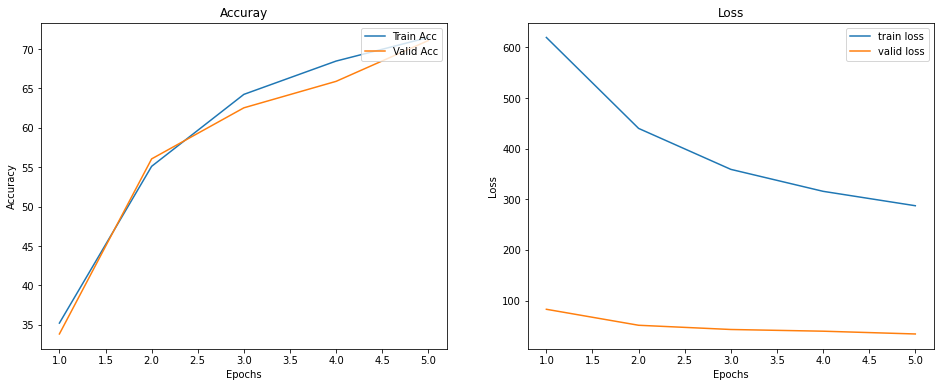

In [ ]:
fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(np.arange(1,NUM_EPOCHS+1),train_acc_array)
plt.plot(np.arange(1,NUM_EPOCHS+1),val_acc_array)
plt.title("Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Acc","Valid Acc"],loc = "upper right")


plt.subplot(122)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),train_loss_array)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),val_loss_array)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'valid loss'], loc="upper right")

plt.show()

In [70]:
def plot_test_result(num_epochs, train_acc, train_loss, val_acc, val_loss):
  fig = plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(np.arange(1, num_epochs + 1), train_acc)
  plt.plot(np.arange(1, num_epochs + 1), val_acc)
  plt.title("Accuray")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Train Acc","Valid Acc"],loc = "upper right")

  plt.subplot(122)
  plt.plot(np.arange(1, num_epochs + 1, dtype=int), train_loss)
  plt.plot(np.arange(1, num_epochs + 1, dtype=int), val_loss)
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(['train loss', 'valid loss'], loc="upper right")

  plt.show()

In [ ]:
# can you create a subset of params exclusing pruned weights ?

<h2>Automatic Hyperparameter Search using Optuna</h2>

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 209 kB 90.8 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 112 kB 74.6 MB/s 
     |████████████████████████████████| 147 kB 71.7 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=95401d6e48f1745b6b0f164a753f98566265ed14b043c8984b8f70db240dba35
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [104]:
import optuna

In [112]:
def objective(trial):

  # generate a model
  curr_model = ResNet18(trial).to(device)

  prune_model(curr_model)

  if device == 'cuda':
    curr_model = torch.nn.DataParallel(curr_model)
    cudnn.benchmark = True


  # trying different optimizers
  optimizer_name_class_1 = trial.suggest_categorical("optimizer", ["SGD",
                                                                   "RMSprop"])

  # optimizer_name_class_2 = trial.suggest_categorical("optimizer", ["Adam",
  #                                                                  "Adadelta", "Adagrad", "ASGD"])
  
  momentum = trial.suggest_float("momentum", 0.0, 1.0)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

  optimizer_class_1 = getattr(optim, optimizer_name_class_1)(curr_model.parameters(),
                                                     lr=lr, momentum=momentum)

  # optimizer_class_2 = getattr(optim, optimizer_name_class_2)(curr_model.parameters(),lr=lr)

  curr_batch_size = trial.suggest_int("batch_size", 64, 256, step=64)

  # defining a loss function
  criterion = nn.CrossEntropyLoss()

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_class_1, T_max=200)

  # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_class_2, T_max=200)

  val_size = 5000
  train_size = len(trainset) - val_size

  train_ds, val_ds = random_split(trainset, [train_size, val_size])

  curr_trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2, drop_last=True)
  
  # run for 100 epochs once the best model is found 
  NUM_EPOCHS = 25

  for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
      scheduler.step()
      train(epoch, model=curr_model, train_loader=curr_trainloader)
      accuracy = evaluate(epoch)
      trial.report(accuracy, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), study_name="resNet-18")

study.optimize(objective, n_trials = 25)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-22 05:12:23,349] A new study created in memory with name: resNet-18



Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



 [======>]  Step: 110ms | Tot: 26s92ms | Train Loss: 2.382 | Train Acc: 10.000% (4493/44928) 234/234 
 [======>]  Step: 11ms | Tot: 1s993ms | Valid Loss: 2.303 | Valid Acc: 9.040% (452/5000) 40/40 
Saving..

Epoch: 1


In [ ]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
print(df)

    value  params_batch_size  params_dropout_rate  params_dropout_rate2  \
0   81.42                192                  0.4                   0.2   
1   85.14                192                  0.1                   0.1   
2   85.76                256                  0.4                   0.3   
3   85.96                192                  0.2                   0.2   
4   86.96                 64                  0.4                   0.2   
5   86.48                192                  0.3                   0.1   
6   86.32                256                  0.3                   0.1   
7   84.80                128                  0.5                   0.0   
8   87.48                256                  0.0                   0.1   
9   86.88                192                  0.4                   0.1   
10  86.98                256                  0.0                   0.0   
11  86.30                256                  0.0                   0.0   
12  86.62                

In [ ]:
from IPython.display import display

display(df)

,value,params_batch_size,params_dropout_rate,params_dropout_rate2,params_lr,params_momentum,params_optimizer
0,81.42,192,0.4,0.2,0.046432,0.929673,RMSprop
1,85.14,192,0.1,0.1,0.029621,0.725203,SGD
2,85.76,256,0.4,0.3,0.017706,0.424324,SGD
3,85.96,192,0.2,0.2,0.000013,0.415626,SGD
4,86.96,64,0.4,0.2,0.003680,0.308545,SGD
5,86.48,192,0.3,0.1,0.001661,0.010862,SGD
6,86.32,256,0.3,0.1,0.000020,0.642634,SGD
7,84.80,128,0.5,0.0,0.030530,0.569134,SGD
8,87.48,256,0.0,0.1,0.000249,0.515801,RMSprop
9,86.88,192,0.4,0.1,0.032970,0.676042,SGD


In [ ]:
from pathlib import Path  
filepath = Path('optuna_out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

In [76]:
opt_hist = optuna.visualization.plot_optimization_history(study)

opt_hist.update_layout(
    yaxis=dict(
        titlefont=dict(size=30),
    ),

    xaxis=dict(
        titlefont=dict(size=30),
    ),

    font=dict(
        size = 30
    )
)

opt_hist.show()

In [ ]:
optuna.visualization.plot_contour(study, params=['batch_size', 'lr'])

In [75]:
param_importance_fig = optuna.visualization.plot_param_importances(study)

param_importance_fig.update_layout(
    yaxis=dict(
        titlefont=dict(size=30),
    ),

    xaxis=dict(
        titlefont=dict(size=30),
    ),

    font=dict(
        size = 30
    )
)

param_importance_fig.show()

In [ ]:
from optuna.trial import TrialState
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

  Number of finished trials:  25
  Number of pruned trials:  4
  Number of complete trials:  21


In [ ]:
# serialize the reult

SERIALIZATION_DIR = "" 

import pickle

with open('study_optuna_nov_21.pickle', 'wb') as f:
    pickle.dump(study, f)

with open('df_optuna_nov_21.pickle', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
print("The best model is")

print(trial.params)

The best model is
{'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'RMSprop', 'momentum': 0.26582732909111395, 'lr': 0.0008781984559717051, 'batch_size': 64}


In [108]:
def objective_2(trial):

  # generate a model
  curr_model = ResNet18(trial).to(device)

  prune_model(curr_model)

  if device == 'cuda':
    curr_model = torch.nn.DataParallel(curr_model)
    cudnn.benchmark = True

  # trying different optimizers

  optimizer_name_class_2 = trial.suggest_categorical("optimizer", ["Adam",
                                                                   "Adadelta", "Adagrad", "ASGD"])
  
  momentum = trial.suggest_float("momentum", 0.0, 1.0)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

  optimizer_class_2 = getattr(optim, optimizer_name_class_2)(curr_model.parameters(),lr=lr)

  curr_batch_size = trial.suggest_int("batch_size", 64, 256, step=64)

  # defining a loss function
  criterion = nn.CrossEntropyLoss()

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_class_2, T_max=200)

  val_size = 5000

  train_size = len(trainset) - val_size

  train_ds, val_ds = random_split(trainset, [train_size, val_size])

  curr_trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2, drop_last=True)
  
  # run for 100 epochs once the best model is found 
  NUM_EPOCHS = 25

  for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
      scheduler.step()
      train(epoch, model=curr_model, train_loader=curr_trainloader)
      accuracy = evaluate(epoch)
      trial.report(accuracy, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return accuracy

In [109]:
print("Running Optuna with Ada family optimizers")

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), study_name="resNet-18-Ada")

study.optimize(objective_2, n_trials = 5)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-22 05:08:12,652] A new study created in memory with name: resNet-18-Ada
[W 2022-11-22 05:08:12,755] Trial 0 failed because of the following error: UnboundLocalError("local variable 'net' referenced before assignment")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-108-96c6e15fe7e7>", line 7, in objective_2
    net = torch.nn.DataParallel(net)
UnboundLocalError: local variable 'net' referenced before assignment


Running Optuna with Ada family optimizers


UnboundLocalError: ignored

<h1>Model Visualization with Tensorboard</h1>

In [ ]:
! pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Run in shell: tensorboard --logdir=runs

In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 0.943s


In [ ]:
!lt --port 6006

your url is: https://legal-mails-turn-34-73-105-255.loca.lt


In [ ]:
print("Running the best model for 100 epochs")

Running the best model for 100 epochs


In [ ]:
jsjhfhfhhfhf